# Imports

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
export_dir = os.getcwd()
from pathlib import Path
import pickle
from collections import defaultdict
import time
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import optuna
import logging
import matplotlib.pyplot as plt
# import wandb

In [2]:
output_type_dict = {
    "VAE":"multiple",
    "MLP":"single",
    "NCF": "single"}

num_users_dict = {
    "ML1M":6037,
    "Yahoo":13797, 
    "Pinterest":19155}

num_items_dict = {
    "ML1M":3381,
    "Yahoo":4604, 
    "Pinterest":9362}

In [3]:
data_name = "Pinterest" ### Can be ML1M, Yahoo, Pinterest
recommender_name = "NCF" ## Can be MLP, VAE, NCF

DP_DIR = Path("processed_data", data_name) 
export_dir = Path(os.getcwd()).parent
files_path = Path(export_dir, DP_DIR)
checkpoints_path = Path(export_dir, "checkpoints")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output_type = output_type_dict[recommender_name] ### Can be single, multiple
num_users = num_users_dict[data_name] 
num_items = num_items_dict[data_name] 

In [ ]:
from ipynb.fs.defs.help_functions import *
importlib.reload(ipynb.fs.defs.help_functions)
from ipynb.fs.defs.help_functions import *

## Data imports and preprocessing

In [4]:
train_data = pd.read_csv(Path(files_path,f'train_data_{data_name}.csv'), index_col=0)
test_data = pd.read_csv(Path(files_path,f'test_data_{data_name}.csv'), index_col=0)
static_test_data = pd.read_csv(Path(files_path,f'static_test_data_{data_name}.csv'), index_col=0)
with open(Path(files_path,f'pop_dict_{data_name}.pkl'), 'rb') as f:
    pop_dict = pickle.load(f)
train_array = train_data.to_numpy()
test_array = test_data.to_numpy()
items_array = np.eye(num_items)
all_items_tensor = torch.Tensor(items_array).to(device)

In [5]:
for row in range(static_test_data.shape[0]):
    static_test_data.iloc[row, static_test_data.iloc[row,-2]]=0
test_array = static_test_data.iloc[:,:-2].to_numpy()

In [6]:
pop_array = np.zeros(len(pop_dict))
for key, value in pop_dict.items():
    pop_array[key] = value

# Recommenders Import

In [ ]:
from ipynb.fs.defs.recommenders_architecture import *
importlib.reload(ipynb.fs.defs.recommenders_architecture)
from ipynb.fs.defs.recommenders_architecture import *

# Define the dict

In [ ]:
kw_dict = {'device':device,
          'num_items': num_items,
           'demographic':False,
          'pop_array':pop_array,
          'all_items_tensor':all_items_tensor,
          'static_test_data':static_test_data,
          'items_array':items_array,
          'output_type':output_type,
          'recommender_name':recommender_name}

# Training

## MLP Train function

In [18]:
train_losses_dict = {}
test_losses_dict = {}
HR10_dict = {}

def MLP_objective(trial):
    
    lr = trial.suggest_float('learning_rate', 0.001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])
    hidden_dim = trial.suggest_categorical('hidden_dim', [64, 128, 256, 512])
    beta = trial.suggest_float('beta', 0, 4)
    epochs = 10
    model = MLP(hidden_dim, **kw_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    hr10 = []
    print(f'======================== new run - {recommender_name} ========================')
    logger.info(f'======================== new run - {recommender_name} ========================')
    
    num_training = train_data.shape[0]
    num_batches = int(np.ceil(num_training / batch_size))

    
    for epoch in range(epochs):
        train_matrix = sample_indices(train_data.copy(), **kw_dict)
        perm = np.random.permutation(num_training)
        loss = []
        train_pos_loss=[]
        train_neg_loss=[]
        if epoch!=0 and epoch%10 == 0:
            lr = 0.1*lr
            optimizer.lr = lr
        
        for b in range(num_batches):
            optimizer.zero_grad()
            if (b + 1) * batch_size >= num_training:
                batch_idx = perm[b * batch_size:]
            else:
                batch_idx = perm[b * batch_size: (b + 1) * batch_size]    
            batch_matrix = torch.FloatTensor(train_matrix[batch_idx,:-2]).to(device)

            batch_pos_idx = train_matrix[batch_idx,-2]
            batch_neg_idx = train_matrix[batch_idx,-1]
            
            batch_pos_items = torch.Tensor(items_array[batch_pos_idx]).to(device)
            batch_neg_items = torch.Tensor(items_array[batch_neg_idx]).to(device)
            
            pos_output = torch.diagonal(model(batch_matrix, batch_pos_items))
            neg_output = torch.diagonal(model(batch_matrix, batch_neg_items))
            
            pos_loss = torch.mean((torch.ones_like(pos_output)-pos_output)**2)
            neg_loss = torch.mean((neg_output)**2)
            
            batch_loss = pos_loss + beta*neg_loss
            batch_loss.backward()
            optimizer.step()
            
            loss.append(batch_loss.item())
            train_pos_loss.append(pos_loss.item())
            train_neg_loss.append(neg_loss.item())
            
        print(f'train pos_loss = {np.mean(train_pos_loss)}, neg_loss = {np.mean(train_neg_loss)}')    
        train_losses.append(np.mean(loss))
        torch.save(model.state_dict(), Path(checkpoints_path, f'MLP_{data_name}_{round(lr,4)}_{batch_size}_{trial.number}_{epoch}.pt'))


        model.eval()
        test_matrix = np.array(static_test_data)
        test_tensor = torch.Tensor(test_matrix[:,:-2]).to(device)
        
        test_pos = test_matrix[:,-2]
        test_neg = test_matrix[:,-1]
        
        row_indices = np.arange(test_matrix.shape[0])
        test_tensor[row_indices,test_pos] = 0
        
        pos_items = torch.Tensor(items_array[test_pos]).to(device)
        neg_items = torch.Tensor(items_array[test_neg]).to(device)
        
        pos_output = torch.diagonal(model(test_tensor, pos_items).to(device))
        neg_output = torch.diagonal(model(test_tensor, neg_items).to(device))
        
        pos_loss = torch.mean((torch.ones_like(pos_output)-pos_output)**2)
        neg_loss = torch.mean((neg_output)**2)
        print(f'test pos_loss = {pos_loss}, neg_loss = {neg_loss}')
        
        hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR = recommender_evaluations(model, **kw_dict)
        hr10.append(hit_rate_at_10)
        print(hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR)
        
        test_losses.append(-hit_rate_at_10)
        if epoch>5:
            if test_losses[-2]<=test_losses[-1] and test_losses[-3]<=test_losses[-2] and test_losses[-4]<=test_losses[-3]:
                logger.info(f'Early stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
                train_losses_dict[trial.number] = train_losses
                test_losses_dict[trial.number] = test_losses
                HR10_dict[trial.number] = hr10
                return max(hr10)
            
    logger.info(f'Stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
    train_losses_dict[trial.number] = train_losses
    test_losses_dict[trial.number] = test_losses
    HR10_dict[trial.number] = hr10
    return max(hr10)

## VAE Train function

In [28]:
train_losses_dict = {}
test_losses_dict = {}
HR10_dict = {}

if data_name == "Pinterest": 
    VAE_config = {"enc_dims": [256,64], "dropout": 0.5, "anneal_cap": 0.2, "total_anneal_steps": 200000}
else:
    VAE_config= {"enc_dims": [512,128], "dropout": 0.5, "anneal_cap": 0.2, "total_anneal_steps": 200000}


def VAE_objective(trial):
    
    lr = trial.suggest_float('learning_rate', 0.001, 0.01)
    batch_size = trial.suggest_categorical('batch_size', [64,128,256])
    epochs = 20
    model = VAE(VAE_config ,**kw_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    hr10 = []
    print('======================== new run ========================')
    logger.info('======================== new run ========================')
    
    for epoch in range(epochs):
        if epoch!=0 and epoch%10 == 0:
            lr = 0.1*lr
            optimizer.lr = lr
        loss = model.train_one_epoch(train_array, optimizer, batch_size)
        train_losses.append(loss)
        torch.save(model.state_dict(), Path(checkpoints_path, f'VAE_{data_name}_{trial.number}_{epoch}_{round(lr,4)}_{batch_size}.pt'))


        model.eval()
        test_matrix = static_test_data.to_numpy()
        test_tensor = torch.Tensor(test_matrix[:,:-2]).to(device)
        test_pos = test_array[:,-2]
        test_neg = test_array[:,-1]
        row_indices = np.arange(test_matrix.shape[0])
        test_tensor[row_indices,test_pos] = 0
        output = model(test_tensor).to(device)
        pos_loss = -output[row_indices,test_pos].mean()
        neg_loss = output[row_indices,test_neg].mean()
        print(f'pos_loss = {pos_loss}, neg_loss = {neg_loss}')
        
        hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR = recommender_evaluations(model, **kw_dict)
        hr10.append(hit_rate_at_10)
        print(hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR)
        
        test_losses.append(pos_loss.item())
        if epoch>5:
            if test_losses[-2]<test_losses[-1] and test_losses[-3]<test_losses[-2] and test_losses[-4]<test_losses[-3]:
                logger.info(f'Early stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
                train_losses_dict[trial.number] = train_losses
                test_losses_dict[trial.number] = test_losses
                HR10_dict[trial.number] = hr10
                return max(hr10)
    
    logger.info(f'Stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
    train_losses_dict[trial.number] = train_losses
    test_losses_dict[trial.number] = test_losses
    HR10_dict[trial.number] = hr10
    return max(hr10)

## NCF training functions

In [18]:
train_losses_dict = {}
test_losses_dict = {}
HR10_dict = {}

## PAY ATTENTION to defince specificly the MLP_model and GMF_model which will be used inside the NCF

def NCF_objective(trial):
    lr = trial.suggest_float('learning_rate', 0.0005, 0.005)
    batch_size = trial.suggest_categorical('batch_size', [32,64,128])
    beta = trial.suggest_float('beta',0, 4)
    epochs = 20
    MLP = MLP_model(hidden_size=8, num_layers=3, **kw_dict)
    #HERE
    MLP_checkpoint = torch.load(Path(checkpoints_path, 'MLP_model_ML1M_0.0001_64_27.pt'))
    MLP.load_state_dict(MLP_checkpoint)
    MLP.train()
    GMF = GMF_model(hidden_size=8, **kw_dict)
    # & HERE
    GMF_checkpoint = torch.load(Path(checkpoints_path, 'GMF_best_ML1M_0.0001_32_17.pt'))
    GMF.load_state_dict(GMF_checkpoint)
    GMF.train()
    model = NCF(factor_num=8, num_layers=3, dropout=0.5, model= 'NeuMF-pre', GMF_model= GMF, MLP_model=MLP, **kw_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    hr10 = []
    print(f'======================== new run - {recommender_name} ========================')
    logger.info(f'======================== new run - {recommender_name} ========================')
    
    num_training = train_data.shape[0]
    num_batches = int(np.ceil(num_training / batch_size))

    
    for epoch in range(epochs):
        train_matrix = sample_indices(train_data.copy(), **kw_dict)
        perm = np.random.permutation(num_training)
        loss = []
        train_pos_loss=[]
        train_neg_loss=[]
        if epoch!=0 and epoch%10 == 0:
            lr = 0.1*lr
            optimizer.lr = lr
        
        for b in range(num_batches):
            optimizer.zero_grad()
            if (b + 1) * batch_size >= num_training:
                batch_idx = perm[b * batch_size:]
            else:
                batch_idx = perm[b * batch_size: (b + 1) * batch_size]    
            batch_matrix = torch.FloatTensor(train_matrix[batch_idx,:-2]).to(device)

            batch_pos_idx = train_matrix[batch_idx,-2]
            batch_neg_idx = train_matrix[batch_idx,-1]
            
            batch_pos_items = torch.Tensor(items_array[batch_pos_idx]).to(device)
            batch_neg_items = torch.Tensor(items_array[batch_neg_idx]).to(device)
            
            pos_output = model(batch_matrix, batch_pos_items)
            neg_output = model(batch_matrix, batch_neg_items)

            pos_loss = -torch.log(pos_output).mean()
            neg_loss = -torch.log(torch.ones_like(neg_output)-neg_output).mean()

            batch_loss = pos_loss + beta*neg_loss
            if batch_loss<torch.inf:
                batch_loss.backward()
                optimizer.step()
            
            loss.append(batch_loss.item())
            train_pos_loss.append(pos_loss.item())
            train_neg_loss.append(neg_loss.item())
            
        print(f'train pos_loss = {np.mean(train_pos_loss)}, neg_loss = {np.mean(train_neg_loss)}')    
        train_losses.append(np.mean(loss))
        torch.save(model.state_dict(), Path(checkpoints_path, f'{recommender_name}2_{data_name}_{round(lr,5)}_{batch_size}_{trial.number}_{epoch}.pt'))


        model.eval()
        test_matrix = np.array(static_test_data)
        test_tensor = torch.Tensor(test_matrix[:,:-2]).to(device)
        
        test_pos = test_matrix[:,-2]
        test_neg = test_matrix[:,-1]
        
        row_indices = np.arange(test_matrix.shape[0])
        test_tensor[row_indices,test_pos] = 0
        
        pos_items = torch.Tensor(items_array[test_pos]).to(device)
        neg_items = torch.Tensor(items_array[test_neg]).to(device)
        
        pos_output = model(test_tensor, pos_items).to(device)
        neg_output = model(test_tensor, neg_items).to(device)
        
        pos_loss = -torch.log(pos_output).mean()
        neg_loss = -torch.log(torch.ones_like(neg_output)-neg_output).mean()
        print(f'test pos_loss = {pos_loss}, neg_loss = {neg_loss}')
        
        hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR = recommender_evaluations(model, **kw_dict)
        hr10.append(hit_rate_at_10)
        print(hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR)
                   
        
        test_losses.append(-hit_rate_at_10)
        if epoch>5:
            if test_losses[-2]<=test_losses[-1] and test_losses[-3]<=test_losses[-2] and test_losses[-4]<=test_losses[-3]:
                logger.info(f'Early stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
                train_losses_dict[trial.number] = train_losses
                test_losses_dict[trial.number] = test_losses
                HR10_dict[trial.number] = hr10
                return max(hr10)
            
    logger.info(f'Stop at trial with batch size = {batch_size} and lr = {lr}. Best results at epoch {np.argmin(test_losses)} with value {np.min(test_losses)}')
    train_losses_dict[trial.number] = train_losses
    test_losses_dict[trial.number] = test_losses
    HR10_dict[trial.number] = hr10
    return max(hr10)

In [19]:
logger = logging.getLogger()

logger.setLevel(logging.INFO)  # Setup the root logger.
logger.addHandler(logging.FileHandler(f"{recommender_name}_{data_name}_Optuna.log", mode="w"))

optuna.logging.enable_propagation()  # Propagate logs to the root logger.
optuna.logging.disable_default_handler()  # Stop showing logs in sys.stderr.

study = optuna.create_study(direction='maximize')

logger.info("Start optimization.")
study.optimize(NCF_objective, n_trials=20)

with open(f"{recommender_name}_{data_name}_Optuna.log") as f:
    assert f.readline().startswith("A new study created")
    assert f.readline() == "Start optimization.\n"
    
    
# Print best hyperparameters and corresponding metric value
print("Best hyperparameters: {}".format(study.best_params))
print("Best metric value: {}".format(study.best_value))

======================== new run - NCF ========================
train pos_loss = 0.1213894068573912, neg_loss = inf
test pos_loss = 0.22046124935150146, neg_loss = 0.551204264163971
0.04489689376142 0.15870529887757764 0.2631166797180893 0.00548159749412686 7.494477611582656
train pos_loss = 0.10376710960020621, neg_loss = 0.5779850189884503
test pos_loss = 0.2101927101612091, neg_loss = 0.5571988224983215
0.040459410075698254 0.15531192900026103 0.25815713912816496 0.005742625946228139 7.444948564123507
train pos_loss = 0.09530452402929465, neg_loss = 0.5479451763133208
test pos_loss = 0.20063135027885437, neg_loss = 0.5691574811935425
0.04202558078830593 0.15740015661707127 0.2550247977029496 0.005742625946228139 7.318173273709151
train pos_loss = 0.08936803179482619, neg_loss = 0.5415122255682945
test pos_loss = 0.20923396944999695, neg_loss = 0.5364846587181091
0.03576089793787523 0.15165753067084312 0.2500652571130253 0.006264682850430697 7.1712701858613235
train pos_loss = 0.0865

Traceback (most recent call last):
  File "C:\ProgramData\anaconda3b\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ruser\AppData\Local\Temp\ipykernel_13452\624387027.py", line 12, in <module>
    study.optimize(NCF_objective, n_trials=20)
  File "C:\ProgramData\anaconda3b\Lib\site-packages\optuna\study\study.py", line 451, in optimize
    _optimize(
  File "C:\ProgramData\anaconda3b\Lib\site-packages\optuna\study\_optimize.py", line 66, in _optimize
    _optimize_sequential(
  File "C:\ProgramData\anaconda3b\Lib\site-packages\optuna\study\_optimize.py", line 163, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3b\Lib\site-packages\optuna\study\_optimize.py", line 251, in _run_trial
    raise func_err
  File "C:\ProgramData\anaconda3b\Lib\site-packages\optuna\study\_optimize.py", li

0 0 0.04489689376142
1 3 0.0498564343513443
2 4 0.055860088749673714
3 5 0.04907334899504046
4 14 0.05664317410597755
5 5 0.052466718872357085
6 11 0.05142260506395197
7 0 0.05272774732445837
8 3 0.05090054815974941
9 10 0.05899243017488906


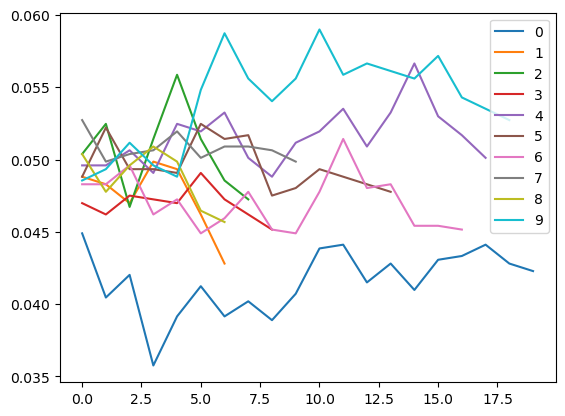

In [20]:
for run in HR10_dict.keys():
    print(run, np.argmax(HR10_dict[run]), max(HR10_dict[run]))
    plt.plot(HR10_dict[run])
plt.legend(HR10_dict.keys())
plt.show()

# Evaluations

## Load the trained recommender

In [ ]:
recommender_path_dict = {
    ("ML1M","VAE"): Path(checkpoints_path, "VAE_ML1M_0.0007_128_10.pt"),
    ("ML1M","MLP"):Path(checkpoints_path, "MLP1_ML1M_0.0076_256_7.pt"),
    ("ML1M","NCF"):Path(checkpoints_path, "NCF_ML1M_5e-05_64_16.pt"),

    ("Yahoo","VAE"): Path(checkpoints_path, "VAE_Yahoo_0.0001_128_13.pt"),
    ("Yahoo","MLP"):Path(checkpoints_path, "MLP2_Yahoo_0.0083_128_1.pt"),
    ("Yahoo","NCF"):Path(checkpoints_path, "NCF_Yahoo_0.001_64_21_0.pt"),
    
    ("Pinterest","VAE"): Path(checkpoints_path, "VAE_Pinterest_12_18_0.0001_256.pt"),
    ("Pinterest","MLP"):Path(checkpoints_path, "MLP_Pinterest_0.0062_512_21_0.pt"),
    ("Pinterest","NCF"):Path(checkpoints_path, "NCF2_Pinterest_9e-05_32_9_10.pt")}


hidden_dim_dict = {
    ("ML1M","VAE"): None,
    ("ML1M","MLP"): 32,
    ("ML1M","NCF"): 8,
    
    ("Yahoo","VAE"): None,
    ("Yahoo","MLP"):32,
    ("Yahoo","NCF"):8,
    
    ("Pinterest","VAE"): None,
    ("Pinterest","MLP"):512,
    ("Pinterest","NCF"): 64}

In [ ]:
hidden_dim = hidden_dim_dict[(data_name, recommender_name)]
recommender_path = recommender_path_dict[(data_name, recommender_name)]

In [ ]:
def load_recommender():
    if recommender_name=='MLP':
        recommender = MLP(hidden_dim, **kw_dict)
    elif recommender_name=='VAE':
        recommender = VAE(VAE_config, **kw_dict)
    elif recommender_name=='MLP_model':
        recommender = MLP_model(hidden_size=hidden_dim, num_layers=3, **kw_dict)
    elif recommender_name=='GMF_model':
        recommender = GMF_model(hidden_size=hidden_dim, **kw_dict)
    elif recommender_name=='NCF':
        MLP_temp = MLP_model(hidden_size=hidden_dim, num_layers=3, **kw_dict)
        GMF_temp = GMF_model(hidden_size=hidden_dim, **kw_dict)
        recommender = NCF(factor_num=hidden_dim, num_layers=3, dropout=0.5, model= 'NeuMF-pre', GMF_model= GMF_temp, MLP_model=MLP_temp, **kw_dict)
    
    recommender_checkpoint = torch.load(Path(checkpoints_path, recommender_path))
    recommender.load_state_dict(recommender_checkpoint)
    recommender.eval()
    for param in recommender.parameters():
        param.requires_grad= False
        
    return recommender

In [ ]:
model = load_recommender()

## plot the distribution of top recommended item accross all users

In [24]:
# plot the distribution of top recommended item accross all users
topk_train = {}
for i in range(len(train_array)):
    vec = train_array[i]
    tens = torch.Tensor(vec).to(device)
    topk_train[i] = int(get_user_recommended_item(tens, model).cpu().detach().numpy())

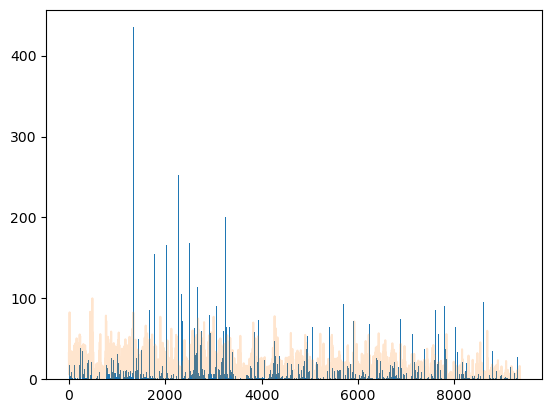

In [25]:
plt.hist(topk_train.values(), bins=1000)
plt.plot(np.array(list(pop_dict.keys())), np.array(list(pop_dict.values()))*100, alpha=0.2)
plt.show()

In [28]:
topk_test = {}
for i in range(len(test_array)):
    vec = test_array[i]
    tens = torch.Tensor(vec).to(device)
    topk_test[i] = int(get_user_recommended_item(tens, model).cpu().detach().numpy())

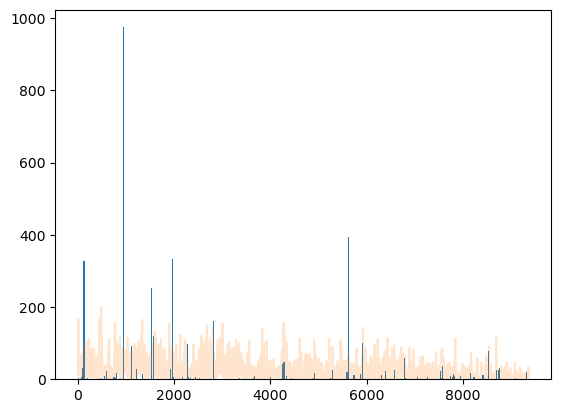

In [29]:
plt.hist(topk_test.values(), bins=400)
plt.plot(np.array(list(pop_dict.keys())), np.array(list(pop_dict.values()))*200, alpha=0.2)
plt.show() 

In [26]:
hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR = recommender_evaluations(model)

In [27]:
print(hit_rate_at_10, hit_rate_at_50, hit_rate_at_100, MRR, MPR)

0.05899243017488906 0.18376403027930044 0.2863482119551031 0.005742625946228139 6.790880186713947
